In [2]:
#Author: Jeffrey Chao
#Assignment: IST652 Final Project

#Part 1: Read in the structure data
import pandas as pd
import numpy as np

#read the data file into Python and save it as a pandas dataframe
#Data Source: https://www.kaggle.com/samuelvedrik/ramen-ratings-latest-update-jan-25-2020
datapath = 'ramen-ratings-2020.csv' 
ramendf = pd.read_csv(datapath, sep=',')

#Verify that the data satisfies the minimum conditions for the project
# "datasets should be chosen that have somewhere between 500 and 4,000 lines 
#  of data with some number of columns between 4 and 50. "
print("The data has {} rows and {} columns".format(ramendf.shape[0],
                                                   ramendf.shape[1]))

#Exploring the data
# print(ramendf.columns.values.tolist())
# print(ramendf.describe())

#Cleaning the data
ramendf.Stars = pd.to_numeric(ramendf.Stars, errors='coerce')
print(len(ramendf.Stars) - len(ramendf.Stars.dropna()))

# Since 15 rows have non-integer or missing ratings, 
# drop them since this is a small amount of data
ramendf = ramendf.dropna()

#Correct typos and inconsistencies in the Country column
ramendf = ramendf.replace({'Country': {'Souh Korea': 'South Korea',
                                      'USA': 'United States',
                                      'UK': 'United Kingdom',
                                      'Phlippines': 'Philippines',
                                      'Sarawak': 'Malaysia'}})

ramendf.head()

The data has 3473 rows and 7 columns
15


,ID,URL,Brand,Variety,Style,Country,Stars
0,3473,https://www.theramenrater.com/2020/04/05/3473-...,MyKuali,White Fish Broth Noodle,Pack,Malaysia,5.00
1,3472,https://www.theramenrater.com/2020/04/05/3472-...,MyKuali,Penang White Curry Noodle (New Recipe),Pack,Malaysia,5.00
2,3471,https://www.theramenrater.com/2020/04/05/3471-...,Ve Wong,Instant Oriental Noodles Soup Chinese Herb - G...,Pack,Taiwan,3.75
3,3470,https://www.theramenrater.com/2020/04/04/3470-...,Myojo,Ippeichan Rich & Sweet Yakisoba,Tray,Japan,5.00
4,3469,https://www.theramenrater.com/2020/04/03/3469-...,Mykuali,Penang Hokkien Prawn Rice Vermicelli Soup,Bowl,Malaysia,5.00


In [3]:
#Part 2: Scrape and organize the unstructured data from Amazon

import csv
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd

def get_url(search_term):
    template = 'https://www.amazon.com/s?k={}&ref=nb_sb_noss_2'
    search_term = search_term.replace(' ', '+')
    return template.format(search_term)

#Tried to use urllib but Amazon does not work with it. Selenium used as workaround
url = get_url('instant ramen')
driver = webdriver.Chrome()
driver.get(url)

soup = BeautifulSoup(driver.page_source, 'html.parser')

def extract_record(item):
    # Description
    atag = item.h2.a
    description = atag.text.strip()
    url = 'https://amazon.com' + atag.get('href')
    rating_int = 0
    review_count_int = 0
    
    try:
        # Price
        price_parent = item.find('span', 'a-price')
        price = price_parent.find('span', 'a-offscreen').text
    except AttributeError:
        return        
        
    try:    
        # Review and Ratings
        rating = item.i.text
        rating_int = float(rating[0:3])
        review_count = item.find('span', {'class': 'a-size-base', 'dir': 'auto'}).text
        review_count_int = int(review_count.replace(',',''))
    except AttributeError:
        rating = ''
        review_count = ''

    result = (url, description, price, rating_int, review_count_int)
    
    return result

SessionNotCreatedException: Message: session not created
from chrome not reachable
  (Session info: chrome=88.0.4324.182)


In [3]:
#Part 2 (coninued)

records = []
results = soup.find_all('div', {'data-component-type': 's-search-result'})

for item in results:
    record = extract_record(item)
    if record:
        records.append(record)
        
amazondf = pd.DataFrame(records)
amazondf.columns = ('url', 'description', 'price', 'rating', 'review_count')

variables1 = ['url', 'description', 'price', 'rating', 'review_count']
filtereddf = amazondf.loc[(amazondf['review_count']>25),variables1]
filtereddf.to_csv('amazonramen.csv', index=False)

In [4]:
#Part 3: Merge the structured dataframe and the cleaned data from Amazon

#Some of the Amazon data cleaning was manually done because it was too difficult 
#to parse name, country, and type using python.

datapath = 'amazonramen_cleaned.csv' 
amazonclean = pd.read_csv(datapath, sep=',')

bigdf = pd.concat([ramendf, amazonclean])
bigdf

,ID,URL,Brand,Variety,Style,Country,Stars
0,3473,https://www.theramenrater.com/2020/04/05/3473-...,MyKuali,White Fish Broth Noodle,Pack,Malaysia,5.00
1,3472,https://www.theramenrater.com/2020/04/05/3472-...,MyKuali,Penang White Curry Noodle (New Recipe),Pack,Malaysia,5.00
2,3471,https://www.theramenrater.com/2020/04/05/3471-...,Ve Wong,Instant Oriental Noodles Soup Chinese Herb - G...,Pack,Taiwan,3.75
3,3470,https://www.theramenrater.com/2020/04/04/3470-...,Myojo,Ippeichan Rich & Sweet Yakisoba,Tray,Japan,5.00
4,3469,https://www.theramenrater.com/2020/04/03/3469-...,Mykuali,Penang Hokkien Prawn Rice Vermicelli Soup,Bowl,Malaysia,5.00
...,...,...,...,...,...,...,...
39,A40,https://amazon.com/Variety-Nongshim-Party-Time...,Nongshim,Nongshim Party Time 10 packs Mix,Pack,South Korea,4.50
40,A41,https://amazon.com/Asha-Healthy-Noodles-indivi...,Asha,Healthy Ramen Noodles,Pack,United States,4.20
41,A42,https://amazon.com/gp/slredirect/picassoRedire...,One Culture Foods,"Bone Broth Instant Cup Noodles, Japanese Spicy...",Cup,United States,4.20
42,A43,https://amazon.com/gp/slredirect/picassoRedire...,Nissin,"Cup Ramen Noodle Soup, Seafood",Pack,United States,4.50


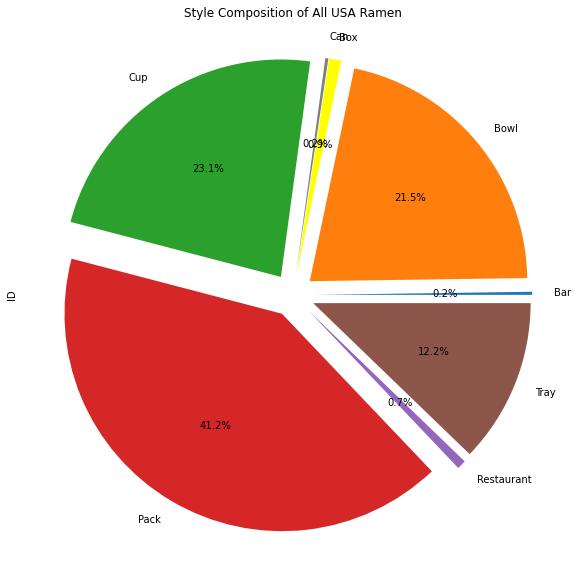

In [5]:
#Question 1: “Which kinds of ramen manufactured in the USA are the tastiest?”

variables1 = ['Variety', 'Style', 'Brand', 'Country', 'ID']
tastyamericanramen = bigdf.loc[(bigdf['Stars']>4.5)&(bigdf['Country']=='United States'), variables1]
americanramen = bigdf.loc[bigdf['Country']=='United States', variables1]
q1a = americanramen.groupby('Style')['ID'].nunique()
q1b = tastyamericanramen.groupby('Style')['ID'].nunique()


# Create a pie chart for visualization
import matplotlib

q1aplot = q1a.plot.pie(autopct='%1.1f%%', 
                        figsize = (10,10),
                        explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
                        colors = ['tab:blue', 'tab:orange', 'yellow', 'gray', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'],
                        title = 'Style Composition of All USA Ramen')

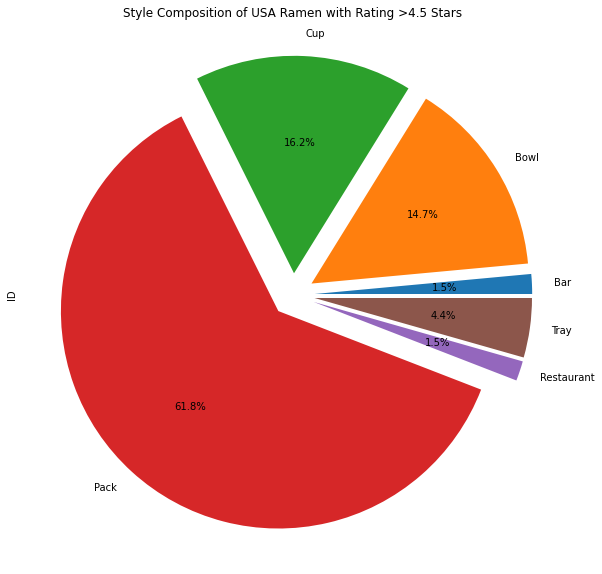

In [6]:
q1bplot = q1b.plot.pie(autopct='%1.1f%%', 
                     figsize = (10,10),
                     explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
                     title = 'Style Composition of USA Ramen with Rating >4.5 Stars')

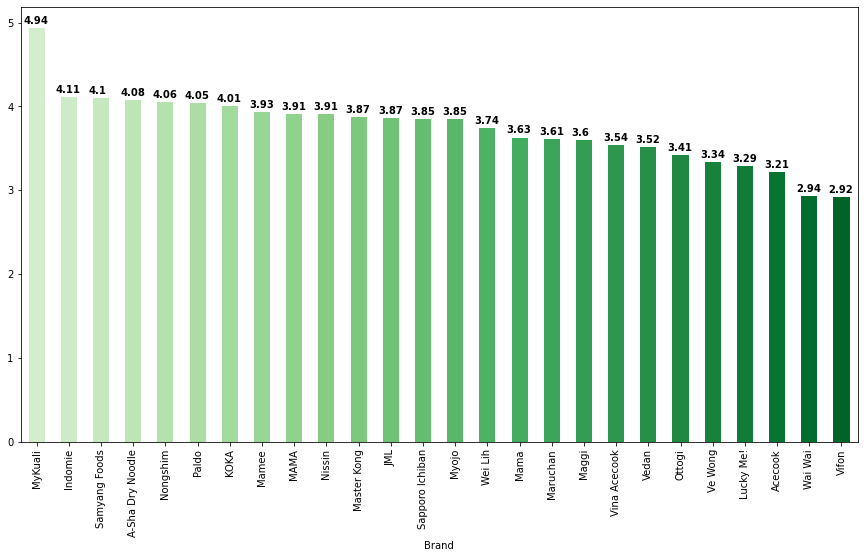

In [7]:
# Question 2: "Which brand produces the tastiest instant ramen?""
ramenbrands = bigdf.groupby(['Brand']).mean()
ramenbrandcount = bigdf.groupby(['Brand']).nunique()
ramenbrands.rename(columns={'Stars': 'Average Rating'}, inplace = True)

# Create a horizontal bar chart for visualization
from matplotlib import cm

ramenbrands = ramenbrands.merge(ramenbrandcount.ID, left_index=True, right_index=True)
ramenbrands.rename(columns={'ID': 'Count'}, inplace = True)
ramenbrands = ramenbrands.loc[(ramenbrands['Count']>25)]
ramenbrands = ramenbrands.sort_values('Average Rating', ascending = False)

colornum = len(ramenbrands.Count)
my_colors = cm.get_cmap("Greens")(np.linspace(.2, .9, colornum))
q2 = ramenbrands['Average Rating'].sort_values(ascending = False)
q2plot = ramenbrands['Average Rating'].sort_values(ascending = False).plot(kind='bar', figsize = (15,8), color = my_colors)
count = -.2
for value in q2:
    q2plot.text(count-0.2,value+0.05, str(round(value,2)), fontweight='bold')
    count +=1

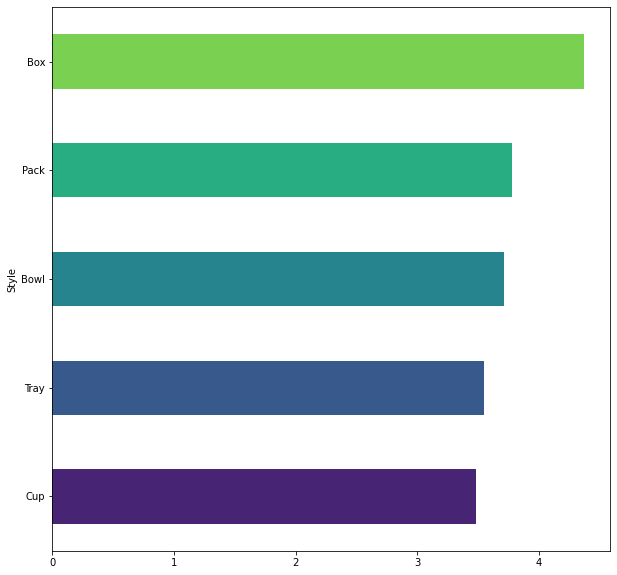

In [8]:
# Question 3: "Are there correlations between the form-factor (style) of the ramen and the rating?"
ramenstyles = bigdf.groupby(['Style']).mean()
ramenstylecount = bigdf.groupby(['Style']).nunique()
ramenstyles.rename(columns={'Stars': 'Average Rating'}, inplace = True)

ramenstyles = ramenstyles.merge(ramenstylecount.ID, left_index=True, right_index=True)
ramenstyles.rename(columns={'ID': 'Count'}, inplace = True)
ramenstyles = ramenstyles.loc[(ramenstyles['Count']>25)]
ramenstyles = ramenstyles.sort_values('Average Rating', ascending = False)

colornum = len(ramenstyles.Count)
my_colors = cm.viridis_r(np.linspace(.9, .2, colornum))
q3plot = ramenstyles['Average Rating'].sort_values(ascending = True).plot(kind='barh', figsize = (10,10), color = my_colors)

In [26]:
ramendf[(ramendf.Style == 'Pack')&(ramendf.Stars>4.5)]

,ID,URL,Brand,Variety,Style,Country,Stars
0,3473,https://www.theramenrater.com/2020/04/05/3473-...,MyKuali,White Fish Broth Noodle,Pack,Malaysia,5.0
1,3472,https://www.theramenrater.com/2020/04/05/3472-...,MyKuali,Penang White Curry Noodle (New Recipe),Pack,Malaysia,5.0
5,3468,https://www.theramenrater.com/2020/04/02/3468-...,Little Couples,Dry Noodle - Onion,Pack,Taiwan,5.0
9,3464,https://www.theramenrater.com/2020/03/29/3464-...,Takamori,Agodashi Udon,Pack,Japan,5.0
11,3462,https://www.theramenrater.com/2020/03/27/3462-...,ABC,Mi Instant Goreng,Pack,Indonesia,5.0
...,...,...,...,...,...,...,...
3423,50,https://www.theramenrater.com/2009/06/30/indom...,Indomie,Mi Goreng,Pack,Indonesia,5.0
3426,47,https://www.theramenrater.com/2009/06/30/indom...,Indomie,Mi Goreng Jumbo Barbecue Chicken,Pack,Indonesia,5.0
3428,45,http://www.theramenrater/2009/06/30/indomie-sa...,Indomie,Mi Goreng Sate,Pack,Indonesia,5.0
3445,28,https://www.theramenrater.com/2009/06/30/nissi...,Nissin,Chikin Ramen,Pack,Japan,5.0
